In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn.init as init
from torch.distributions import Categorical
import numpy as np
from tqdm import tqdm
import pandas as pd

from model.CustomDataSet import CustomDataSetRNN
from model.Tokenizer import SimpleTokenizerV1
from environnement.environnement1Str import Environnement1
from environnement.environnement3Str import Environnement3
from environnement.environnement6Str import Environnement6
from environnement.small_loop import small_loop
from environnement.gridWorld import gridWorld
from model.RNN import LSTM_GenText
from inter.simpleInteraction import simpleInteraction as inter

from outil import *

# Environement
Nous prennons un environnement pour obtenir les tokens que nous voulons générer

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


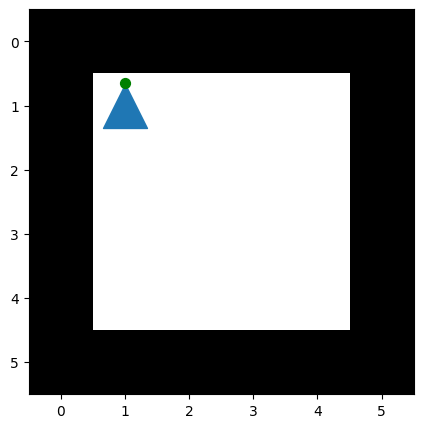

In [2]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
actions, outcomes = [], []
env_test.display_world()

# Liste vocab
Nous pouvons maintenant définir notre liste de vocabulaire et notre tokenizer

In [3]:
list_vocab = ['<pad>']
# Nous notons toutes les interactions techniquement possible
for act in env_test.get_actions():
    for fb in env_test.get_outcomes():
        list_vocab.append((act, fb))

# Nous pouvons supprimer des interactions qui ne sont en réalité pas possible.
list_vocab.remove(('turn_left', 'wall'))
list_vocab.remove(('turn_right', 'wall'))
for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)
tokenizer = SimpleTokenizerV1(vocab=tmp)
# Test tokenizer
# print(tokenizer.encode(("forward", "empty")))
# print(tokenizer.encode("<pad>"))

<pad>
('forward', 'wall')
('forward', 'empty')
('turn_left', 'empty')
('turn_right', 'empty')
('feel_front', 'wall')
('feel_front', 'empty')
('feel_left', 'wall')
('feel_left', 'empty')
('feel_right', 'wall')
('feel_right', 'empty')
{'<pad>': 0, ('forward', 'wall'): 1, ('forward', 'empty'): 2, ('turn_left', 'empty'): 3, ('turn_right', 'empty'): 4, ('feel_front', 'wall'): 5, ('feel_front', 'empty'): 6, ('feel_left', 'wall'): 7, ('feel_left', 'empty'): 8, ('feel_right', 'wall'): 9, ('feel_right', 'empty'): 10}


# Génération de texte
## Entrainement ?

Dans notre cas nous n'avons pas de données au début, l'agent n'a pas encore intéragit avec son environement. Donc nous n'avons pas de train possible.

## Prompt
Mais pour que le LSTM génére du texte il nous faut un prompt. Pour se faire nous avons plusieurs possiblité, soit nous appliquons une action de base (Ce qui est fait pour les agents précédent) soit nous lui donnons le token \<pad\>. Vue que le modèl n'est pas entrainner cela n'a pas d'importence. 


A noter que si plus tard nous lui donnons un entrainement qui utilise \<pad\> Alors il n'est plus pertinent d'utiliser cette balise comme cela.

In [4]:
# Mots que l'on veut prompt (ca doit être une liste)
input_tokens = tokenizer.encode(["<pad>"])

# Model
Nous pouvons maintenant definir le modèl, nous prennons une configuration de base.

In [5]:
# Model
torch.manual_seed(1)
num_layers = 2
hidden_size = 128
temp = 1.0
lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0.1
)

# Génération
## Première génération
Nous passons au modèle le prompt et nous voulons qu'il génere une phrase. Notre objectif est d'atteindre l'interaction ('forward', 'Empty'). Dans ce cas il suffit d'arreter la phrase à ce moment.

## FONCTION DE GÉNERATION 1ER VERSION

In [6]:
def generate_sentence(lstm_generator:nn.Module, input_tokens, tokenizer:SimpleTokenizerV1, temp:int=1.0, max_len:int=50, end_token:int|None=2):
    lstm_generator.eval()
    log_tokens = []
    
    interactions = []
    probability = {}
    for i in range(tokenizer.size_vocab):
        probability[tokenizer.decode(i)] = []
    
    # Disable gradient calculation
    with torch.no_grad():
        # Initialize hidden and memory states
        hidden = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)
        memory = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)

        # Generate text
        for i in range(max_len): # On met une limite de 100 tokens
            # Forward pass through LSTM generator
            data_pred, hidden, memory = lstm_generator(input_tokens, hidden, memory)

            # Sample from the distribution of probabilities (with temperature)
            dist = Categorical(logits=data_pred[:, -1] / temp)
            input_tokens = dist.sample().reshape(1, 1)

            # Append generated token to log_tokens
            log_tokens.append(input_tokens.cpu())
            
            interactions.append(tokenizer.decode(input_tokens.item()))            
            proba_tmp = F.softmax(data_pred/temp, -1).cpu().numpy().flatten()
            for i in range(tokenizer.size_vocab):
                probability[tokenizer.decode(i)].append(round(float(proba_tmp[i]), 3))

            # Check for end-of-sentence token
            if input_tokens.item() == end_token: # Si le token est ('forward', 'empty') on s'arrête
                break
    tmp = probability
    tmp.update({'interactions choisies': interactions})
    df_interactions = pd.DataFrame(tmp)
    return log_tokens, data_pred, df_interactions

 le tensor input : 
tensor([[0]])

 les tensor d'output :
('feel_left', 'empty')
<pad>
('turn_right', 'empty')
('feel_front', 'wall')
('turn_left', 'empty')
('forward', 'empty')
[tensor([[8]]), tensor([[0]]), tensor([[4]]), tensor([[5]]), tensor([[3]]), tensor([[2]])]


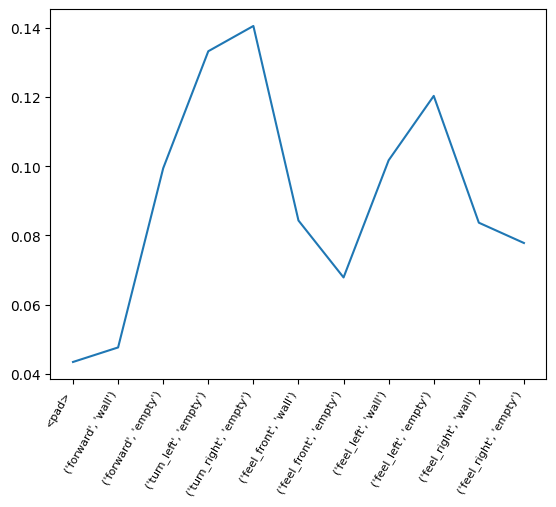

In [ ]:
torch.manual_seed(1)
# Nous devons reshape input_tokens pour qu'il soit de la forme (1, -1)
# Pour résumer nous ajoutons une dimension pour le batch
input_tokens = tokenizer.encode(["<pad>"])
input_tokens = torch.tensor(input_tokens).reshape(1, -1)
print("\033[0;32m le tensor input : \033[0m")
print(input_tokens)

log_tokens, data_pred, df = generate_sentence(lstm_generator, input_tokens, tokenizer=tokenizer)
print()
print("\033[0;32m les tensor d'output :\033[0m")
for i in log_tokens:
    print(tokenizer.decode(i.item()))
print(log_tokens)

# La distribution de probabilité
# ce qui correspond à la prédiction du modèle pour le prochain token
# Cette distribution est calculée avec la fonction softmax et dépand de la température
plt.xticks(range(len(list_vocab)), list_vocab, fontsize=8, rotation=60, ha='right')
plt.plot(F.softmax(data_pred/temp, -1).cpu().numpy().flatten())

## Output
Ce que le modèl sort est très variable si nous ne fixons pas la seed. Le modèl propose une distribution corespondant à l'initialisation de ses poids (aléatoirement).
## Appliquation de la génération
Avec notre premier output nous pouvons demander à notre "agent" d'appliquer les actions des tokens pour vérifier si les prédictions sont bonne ou non. 
De manière évidente en début les prédictions ont que très peu de chance d'être bonne. Ce qui est normal l'agent doit découvrir son environement.
## Fonction RUN TOKEN

In [8]:
def run_token(tokens:torch.Tensor, env_to_run:env, path:str|None=None):
    """Applique toutes les actions des tokens

    Args:
        token (torch.Tensor): La sortie brut du modèle de prédiction
        env (env): L'environnement dans lequel on veut appliquer les actions

    Returns:
        list: La liste des actions
        list: La liste des outcomes
    """
    actions = []
    outcomes = []
    for tok in tokens:
        interaction:tuple|str = tokenizer.decode(tok.item())
        if interaction in ["<pad>"]: # Liste des tokens qui ne correspondent à aucune action
            continue
        actions.append(interaction[0]) # On ajoute l'action à la liste
        outcomes.append(env_to_run.outcome(actions[-1])) # On récupère l'outcome de l'action
        if path is not None:
            env_to_run.save_world(path=path)
    return actions, outcomes

In [9]:
tokens = log_tokens
actions, outcomes = run_token(tokens, env_test)
print("Les actions tirées de la génération du modèle")
print(actions)
print("Les outcomes réel de l'environnement")
print(outcomes)

Les actions tirées de la génération du modèle
['feel_left', 'turn_right', 'feel_front', 'turn_left', 'forward']
Les outcomes réel de l'environnement
['wall', 'empty', 'empty', 'empty', 'wall']


# Train
## Jeu de données
Pour entrainer le modèle, il nous faut des données. Nous pouvons récupérer les interactions que "l'agent" à fait.
### Traitement des interactions
Nous avons les actions et outcomes, nous devons les transformers en token. Il nous faut une taille de contexte pour que l'entrainement soit fixe (cela améliore les performances). Nous pouvons prendre une grande taille que nous comblerons par des \<pad\>

#### Transformation en token

## Fonction ACTION OUT to TOKEN

In [10]:
def action_outcome_to_token(actions, outcomes):
    token = []
    for i in range(len(actions)):
        token.append(tokenizer.encode((actions[i], outcomes[i])))
    return token

In [11]:
print(f"\033[0;32mLes actions\033[0m {actions} \n\033[0;32met outcomes\033[0m {outcomes}")
seq_token = action_outcome_to_token(actions, outcomes)
print(f"\033[0;32mLes tokens déduit\033[0m {seq_token}")


Les actions ['feel_left', 'turn_right', 'feel_front', 'turn_left', 'forward'] 
et outcomes ['wall', 'empty', 'empty', 'empty', 'wall']
Les tokens déduit [7, 4, 6, 3, 1]


#### Création du data set
Pour avoir le plus possible de phrase avec peu d'interaction, nous découpons le plus possible la séquence d'interaction faites par l'agent.

In [12]:
# Création du data set :
def create_data(tokens, context_length, padding, min = 1):
    """
    Create the data
    """
    sentences = []
    for range_cut in range(min, context_length + 1):
        for i in range(0, len(tokens) - range_cut, 1):
            sentences.append(tokens[i:i + range_cut])
            sentences[-1] = sentences[-1] + [padding] * (context_length - len(sentences[-1]))
    return sentences

data_set = create_data(seq_token, 10, tokenizer.encode("<pad>"), min = 1)
print(f"\033[0;32mLe data set\033[0m")
for i in data_set:
    print(i)
    # print(tokenizer.decode(i))
    # print()

Le data set
[7, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[4, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[6, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[7, 4, 0, 0, 0, 0, 0, 0, 0, 0]
[4, 6, 0, 0, 0, 0, 0, 0, 0, 0]
[6, 3, 0, 0, 0, 0, 0, 0, 0, 0]
[7, 4, 6, 0, 0, 0, 0, 0, 0, 0]
[4, 6, 3, 0, 0, 0, 0, 0, 0, 0]
[7, 4, 6, 3, 0, 0, 0, 0, 0, 0]


#### Token de fin dans les phrases
Actuelement notre data set fini par des \<pad\>, si nous laissons notre data set comme ceci, le modèle peut générer beaucoup de balise \<pad\> sans chercher à finir par ('forward', 'empty'). Hors nous voulons que le modèls trouve un moyen d'arriver a cette interaction.  
Nous devons donc ne garder que les phrases qui contiennent ('forward', 'empty').

In [13]:
# Data set finnissant par un token de fin
def create_data(tokens, context_length, padding, min = 1):
    """
    Create the data
    """
    sentences = []
    for range_cut in range(min, context_length + 1):
        for i in range(0, len(tokens) - range_cut + 1, 1):
            sequence = tokens[i:i + range_cut]
            if tokenizer.encode(('forward', 'empty')) in sequence:
                sentences.append(tokens[i:i + range_cut] + \
                                 [padding] * (context_length - len(tokens[i:i + range_cut])))
    return sentences

data_set = create_data(seq_token, 10, tokenizer.encode("<pad>"), min = 1)
print(f"\033[0;32mLe data set\033[0m")
for i in data_set:
    print(i)

print(f"\033[0;32mLa séquence \033[0m")
print(tokenizer.decode(seq_token))

Le data set
La séquence 
[('feel_left', 'wall'), ('turn_right', 'empty'), ('feel_front', 'empty'), ('turn_left', 'empty'), ('forward', 'wall')]


#### Plus d'interactions
Il se peut que pour la première génération du modèles n'arrive pas à faire réellement l'interactation ('forward', 'empty'). Pour arriver a cette intéraction au moins une fois, nous ne pouvons pas demander au modèl de nous générer en boucle des interactions a appliqué, car le modèl donneras toujours le même output. L'éxecusion seepder donne :  
`('feel_left', 'wall'), ('turn_right', 'empty'), ('feel_front', 'empty'), ('turn_left', 'empty'), ('forward', 'wall')`  
Hors répeter ses actions en boucle sur l'environement, ne permet d'arriver à l'interaction souhaiter.

##### Exploration aléatoire
En considérant que le robot n'a aucune connnaissance sur l'environement, nous pouvons lancé des actions aléatoirement jusqu'à obtenir l'interaction : `('forward', 'empty')`

In [14]:
while seq_token[-1] != tokenizer.encode(('forward', 'empty')):
    action_random = np.random.choice(env_test.get_actions())
    outcome_random = env_test.outcome(action_random)
    seq_token.append(tokenizer.encode((action_random, outcome_random)))
    env_test.save_world(path="imgToGif2")
    
print(f"\033[0;32mLa séquence \033[0m")
print(tokenizer.decode(seq_token))
print(f"Nombre de token : {len(seq_token)}")

La séquence 
[('feel_left', 'wall'), ('turn_right', 'empty'), ('feel_front', 'empty'), ('turn_left', 'empty'), ('forward', 'wall'), ('forward', 'wall'), ('turn_right', 'empty'), ('feel_front', 'empty'), ('turn_left', 'empty'), ('turn_right', 'empty'), ('forward', 'empty')]
Nombre de token : 11


#### Data set avec forward empty
Nous sommes maintenant sùr que notre modèle peut apprendre des "phrases" avec l'interaction souhaité, voici le data set :

In [15]:
data_set = create_data(seq_token, 10, tokenizer.encode("<pad>"), min = 1)
print(f"\033[0;32mLe data set\033[0m")
for i in data_set:
    print(i)

print(f"\033[0;32mLa séquence \033[0m")
print(tokenizer.decode(seq_token))

Le data set
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[4, 2, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 4, 2, 0, 0, 0, 0, 0, 0, 0]
[6, 3, 4, 2, 0, 0, 0, 0, 0, 0]
[4, 6, 3, 4, 2, 0, 0, 0, 0, 0]
[1, 4, 6, 3, 4, 2, 0, 0, 0, 0]
[1, 1, 4, 6, 3, 4, 2, 0, 0, 0]
[3, 1, 1, 4, 6, 3, 4, 2, 0, 0]
[6, 3, 1, 1, 4, 6, 3, 4, 2, 0]
[4, 6, 3, 1, 1, 4, 6, 3, 4, 2]
La séquence 
[('feel_left', 'wall'), ('turn_right', 'empty'), ('feel_front', 'empty'), ('turn_left', 'empty'), ('forward', 'wall'), ('forward', 'wall'), ('turn_right', 'empty'), ('feel_front', 'empty'), ('turn_left', 'empty'), ('turn_right', 'empty'), ('forward', 'empty')]


### Data set
Maintenant que le data set est créer nous pouvons utiliser pytorch pour gérer notre data train. (Nous mettons aussi les données sous forme de tensor)

## Class CustomDataSetTextGenByToken

In [16]:
class CustomDataSetTextGenByToken(Dataset):
    def __init__(self, token, context_lenght:int, id_pad:int=0, min:int = 1):
        """
        Creates a custom dataset
        """
        # assert context_lenght % 2 != 0, "context_lenght must be odd"
        # assert len(actions) == len(outcomes), "actions and outcomes must have the same length"
        assert context_lenght > 0, "context_lenght can't be negative or zero"

        self.context_lenght = context_lenght
        self.tokenizer = tokenizer
        self.dim_out = tokenizer.size_vocab
        self.token = token
        self.padding = id_pad
        self.min = min
        self.data = self.create_data()

    # Fonction vue précédament
    def create_data(self):
        """
        Create the data
        """
        sentences = []
        for range_cut in range(self.min, self.context_lenght +1):
            for i in range(0, len(self.token) + 1 - range_cut, 1):
                sequence = self.token[i:i + range_cut]
                if self.tokenizer.encode(('forward', 'empty')) in sequence:
                    sentences.append(self.token[i:i + range_cut] + \
                                    [self.padding] * (self.context_lenght - len(self.token[i:i + range_cut])))
        
        return sentences

    def __len__(self):
        """
        Get the length of the dataset
        :return: length
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get the item at the index idx

        :param idx: index
        :return: x
        """
        return torch.tensor(self.data[idx])
    
class CustomDataSetTextGenByTokenV2(Dataset):
    def __init__(self, token, context_lenght:int, id_pad:int=0, min:int = 1):
        """
        Creates a custom dataset
        """
        # assert context_lenght % 2 != 0, "context_lenght must be odd"
        # assert len(actions) == len(outcomes), "actions and outcomes must have the same length"
        assert context_lenght > 0, "context_lenght can't be negative or zero"

        self.context_lenght = context_lenght
        self.tokenizer = tokenizer
        self.dim_out = tokenizer.size_vocab
        self.token = token
        self.padding = id_pad
        self.min = min
        self.data = self.create_data()

    # Fonction vue précédemment
    def create_data(self):
        """
        Create the data
        """
        sentences = []
        for range_cut in range(self.min, self.context_lenght +1):
            for i in range(0, len(self.token) + 1 - range_cut, 1):
                sequence = self.token[i:i + range_cut]
                sentences.append(
                    sequence + [self.padding] * (self.context_lenght - len(self.token[i:i + range_cut]))
                )
        
        return sentences

    def __len__(self):
        """
        Get the length of the dataset
        :return: length
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get the item at the index idx

        :param idx: index
        :return: x
        """
        return torch.tensor(self.data[idx])

In [17]:
print(seq_token)
data_set = CustomDataSetTextGenByToken(
    token=seq_token,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=10,
    min=1)
print(f"\033[0;32mLe data set\033[0m")
for i in data_set:
    print(i)

[7, 4, 6, 3, 1, 1, 4, 6, 3, 4, 2]
Le data set
tensor([2, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([4, 2, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([3, 4, 2, 0, 0, 0, 0, 0, 0, 0])
tensor([6, 3, 4, 2, 0, 0, 0, 0, 0, 0])
tensor([4, 6, 3, 4, 2, 0, 0, 0, 0, 0])
tensor([1, 4, 6, 3, 4, 2, 0, 0, 0, 0])
tensor([1, 1, 4, 6, 3, 4, 2, 0, 0, 0])
tensor([3, 1, 1, 4, 6, 3, 4, 2, 0, 0])
tensor([6, 3, 1, 1, 4, 6, 3, 4, 2, 0])
tensor([4, 6, 3, 1, 1, 4, 6, 3, 4, 2])


### Data loader
Nous faisons appel a pytorch pour créer un data Loader

In [18]:
data_loader_train = DataLoader(
    data_set, # C'est le data set que nous avons créé
    batch_size=1,
    shuffle=True,
    num_workers=8
)

### Loss et opti

In [19]:
opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss(ignore_index=tokenizer.encode("<pad>"))

### Token Drop ?
Le fais de cacher certain mots dans l'apprantissage du modèle (token drop) permet d'éviter le surapprentissage et permet de résister a des variations dans les phrases. Le modèle apprends a tiré l'information de certain mots important et pas de tous.

<!-- Je ne suis pas encore sûr mais le token drop améliore les performances avec des tailles variable lors de l'entrainement -->

La question d'utiliser un token drop dans notre cas n'est pas facil. Il faut tester sur un jeu de données suffisant. Mais il est possible que les résultat dépende trop de l'environement. Un environement simple ou il est facil "d'overfit" pour être bon, n'aura certainement pas beson de token drop. Mais pour des environement complexe, il se peut que le token drop améliore les performence.

## CLASS TOKEN DROP

In [20]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

## Training
L'entrainement du modèle suit la logique de n'importe quels réseaux de neurone. Il y a quelque variations comme pour la target. Le data loader ne donne pas de target, c'est à nous de le créer. Pour se faire nous prennons chaque phrase, sur ces phrases nous prennons chaque mots et le modèle doit deviner le mots d'après. Exemple :  
Avec la phrase `(feel_front, wall), (turn_right, empty), (feel_front, empty), (forward, empty)`
Ce qui est passer au modèl est `(feel_front, wall), (turn_right, empty), (feel_front, empty)` et nous voulons qu'a chaque cellule avoir `(turn_right, empty), (feel_front, empty), (forward, empty)`

## FONCTION TRAIN 1ER VERSION

In [21]:
def train(lstm_generator:nn.Module, data_loader_train:DataLoader, nb_epoch:int, optimizer, loss_fn, td:TokenDrop|None=None):
    # Monitor training loss and entropy
    training_loss_logger = []
    entropy_logger = []

    for _ in tqdm(range(nb_epoch)):
        # Set LSTM generator model to training mode
        lstm_generator.train()
        # Iterate over batches in training data loader
        for text in tqdm(data_loader_train, desc="Training", leave=False):
            # Transform text tokens using training transform and move to device
            bs = text.shape[0]
            
            # Randomly drop input tokens
            if td is not None:
                input_text = td(text[:, 0:-1])
            else:
                input_text = text[:, 0:-1]
            output_text = text[:, 1:]
            
            # Or not drop tokens
            # input_text = text[:, 0:-1]
            # output_text = text[:, 1:]
            
            # Initialize the memory buffers
            hidden = torch.zeros(lstm_generator.num_layers, bs, lstm_generator.hidden_size)
            memory = torch.zeros(lstm_generator.num_layers, bs, lstm_generator.hidden_size)
            
            # Forward pass through the LSTM generator
            pred, hidden, memory = lstm_generator(input_text, hidden, memory)

            # Calculate loss
            loss = loss_fn(pred.transpose(1, 2), output_text)
            
            # Zero gradients, perform backward pass, and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Log training loss
            training_loss_logger.append(loss.item())
            
            # Log entropy during training (for monitoring)
            with torch.no_grad():
                dist = Categorical(logits=pred)
                entropy_logger.append(dist.entropy().mean().item())
    return training_loss_logger, entropy_logger

100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


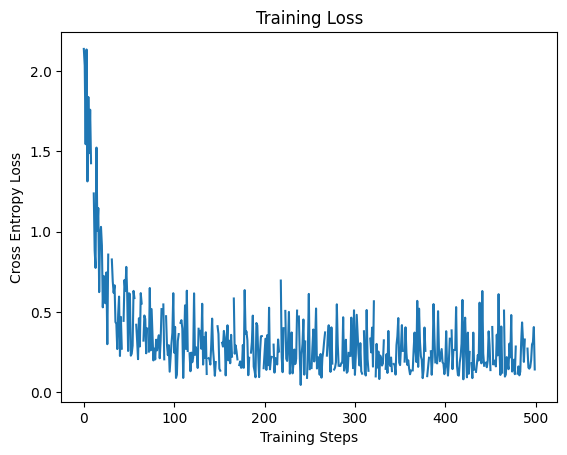

Text(0.5, 1.0, 'Entropy')

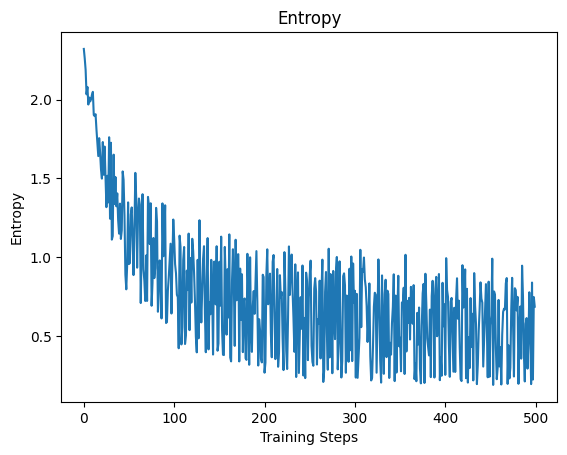

In [22]:
td = TokenDrop(prob=0.1, pad_token=tokenizer.encode("<pad>"), num_special=1)
td = None
training_loss_logger, entropy_logger = train(lstm_generator=lstm_generator, 
                                            nb_epoch=50, 
                                            data_loader_train=data_loader_train,
                                            optimizer=opti, 
                                            loss_fn=loss_fct)
# Display training loss and entropy
plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()
plt.close()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
# plt.show()

# Nouvelle génération
Maintenant que notre modèle c'est entrainer, il peut générer de nouvelles chose !
## Prompt
Le prompt pour la nouvelle génération sera les X dernière itération. (Je n'ai pas encore d'idée fixe pour ce x)

[4, 6, 3, 1, 1, 4, 6, 3, 4, 2]


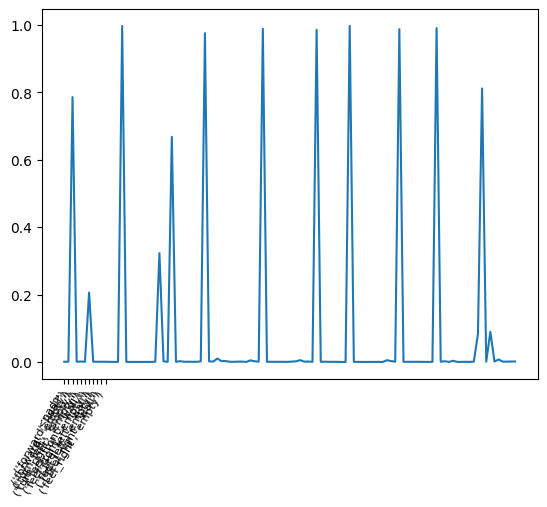

In [23]:
torch.manual_seed(1)
if len(seq_token) > 10:
    input_tokens = seq_token[-10:]
else:
    input_tokens = seq_token
print(input_tokens)
input_tokens = torch.tensor(input_tokens).reshape(1, -1)
log_tokens, data_pred, df = generate_sentence(lstm_generator, input_tokens, tokenizer=tokenizer)
plt.xticks(range(len(list_vocab)), list_vocab, fontsize=8, rotation=60, ha='right')
plt.plot(F.softmax(data_pred/temp, -1).cpu().numpy().flatten())

Ce qu'il faut retenir de ce graphique est que le modèl est très sur de lui pour chaque prédiction

In [24]:
for i in log_tokens:
    print(tokenizer.decode(i.item()))
    
actions, outcomes = run_token(log_tokens, env_test)
print("Les actions tirées de la génération du modèle")
print(actions)
print("Les outcomes réel de l'environnement")
print(outcomes)

('forward', 'empty')
Les actions tirées de la génération du modèle
['forward']
Les outcomes réel de l'environnement
['empty']


In [25]:
seq_token += action_outcome_to_token(actions, outcomes)
print(f"\033[0;32mLa séquence \033[0m")
print(tokenizer.decode(seq_token))

La séquence 
[('feel_left', 'wall'), ('turn_right', 'empty'), ('feel_front', 'empty'), ('turn_left', 'empty'), ('forward', 'wall'), ('forward', 'wall'), ('turn_right', 'empty'), ('feel_front', 'empty'), ('turn_left', 'empty'), ('turn_right', 'empty'), ('forward', 'empty'), ('forward', 'empty')]


# Boucle (1er version)
Maintenant que nous avons vue toutes les étapes, nous pouvons tenter de faire un modèle qui comprends l'environement !  
Il est important de noté qu'il n'y a aucune volonté de faure un certain chemin. Le modèle peut tout a fait apprendre "forward", "wall" en boucle.
## Initialisation

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


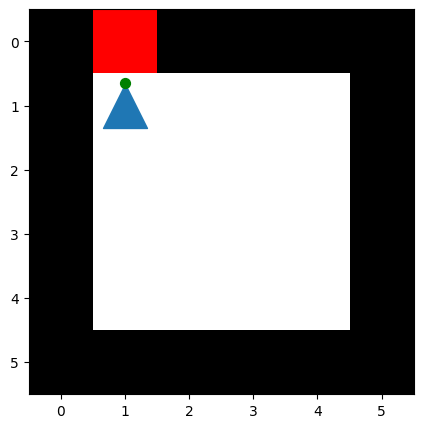

<pad>
('forward', 'wall')
('forward', 'empty')
('turn_left', 'empty')
('turn_right', 'empty')
('feel_front', 'wall')
('feel_front', 'empty')
('feel_left', 'wall')
('feel_left', 'empty')
('feel_right', 'wall')
('feel_right', 'empty')
{'<pad>': 0, ('forward', 'wall'): 1, ('forward', 'empty'): 2, ('turn_left', 'empty'): 3, ('turn_right', 'empty'): 4, ('feel_front', 'wall'): 5, ('feel_front', 'empty'): 6, ('feel_left', 'wall'): 7, ('feel_left', 'empty'): 8, ('feel_right', 'wall'): 9, ('feel_right', 'empty'): 10}


In [26]:
# torch.manual_seed(1)
# Historique des actions et outcomes
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
all_actions, all_outcomes = [], []
all_actions.append('forward') # Première action de base 
all_outcomes.append(env_test.outcome('forward')) # Première outcome de base
# Cette première interaction nous servira de premier prompt
seq_token = [tokenizer.encode((all_actions[0], all_outcomes[0]))]

env_test.display_world()

lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=16,
    emb_size=16,
    num_layers=2,
    dropout=0.1
)
opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss(ignore_index=tokenizer.encode("<pad>"))

list_vocab = ['<pad>']
# Nous notons toutes les interactions techniquement possible
for act in env_test.get_actions():
    for fb in env_test.get_outcomes():
        list_vocab.append((act, fb))

# Nous pouvons suprimer des interactions qui ne sont en réalité pas possible.
list_vocab.remove(('turn_left', 'wall'))
list_vocab.remove(('turn_right', 'wall'))
for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)
tokenizer = SimpleTokenizerV1(vocab=tmp)

## Vérification faire au moins une fois forward empty

In [27]:
np.random.seed(1)
while seq_token[-1] != tokenizer.encode(('forward', 'empty')):
    action_random = np.random.choice(env_test.get_actions())
    outcome_random = env_test.outcome(action_random)
    seq_token.append(tokenizer.encode((action_random, outcome_random)))
    env_test.save_world(path="imgToGif2")
    
print(f"\033[0;32mLa séquence \033[0m")
print(tokenizer.decode(seq_token))
print(seq_token)
print(f"Nombre d'interaction créée aléatoirement: {len(seq_token)}")

La séquence 
[('forward', 'wall'), ('feel_right', 'empty'), ('feel_front', 'wall'), ('feel_left', 'wall'), ('forward', 'wall'), ('turn_left', 'empty'), ('feel_front', 'wall'), ('feel_right', 'wall'), ('forward', 'wall'), ('forward', 'wall'), ('turn_left', 'empty'), ('feel_left', 'empty'), ('feel_right', 'wall'), ('feel_left', 'empty'), ('turn_left', 'empty'), ('turn_right', 'empty'), ('feel_left', 'empty'), ('feel_right', 'wall'), ('turn_right', 'empty'), ('feel_left', 'empty'), ('feel_front', 'wall'), ('feel_left', 'empty'), ('turn_right', 'empty'), ('feel_left', 'wall'), ('feel_right', 'empty'), ('turn_right', 'empty'), ('feel_left', 'wall'), ('turn_left', 'empty'), ('turn_left', 'empty'), ('forward', 'wall'), ('feel_right', 'wall'), ('turn_left', 'empty'), ('turn_left', 'empty'), ('feel_right', 'empty'), ('turn_left', 'empty'), ('turn_left', 'empty'), ('forward', 'wall'), ('feel_left', 'empty'), ('turn_left', 'empty'), ('forward', 'empty')]
[1, 10, 5, 7, 1, 3, 5, 9, 1, 1, 3, 8, 9, 8

## Éxecution de la boucle

Pour voir étapes par étapes se qui se passe si nous laissons le modèles explorer, éxecuter plusieurs fois la cellule python suivante :

Le prompt [9, 3, 3, 10, 3, 3, 1, 8, 3, 2]
('feel_right', 'wall')
('turn_left', 'empty')
('turn_left', 'empty')
('feel_right', 'empty')
('turn_left', 'empty')
('turn_left', 'empty')
('forward', 'wall')
('feel_left', 'empty')
('turn_left', 'empty')
('forward', 'empty')



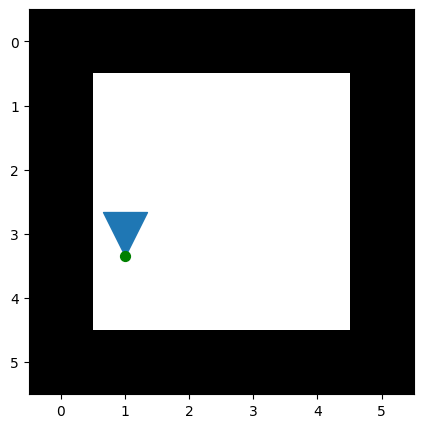

DataFrame des interactions
  Interaction générer Action appliquer Outcome réel verifier
0  (feel_right, wall)       feel_right         wall  Correct
1    (forward, empty)          forward        empty  Correct
nombre de bonne prédiction : 2 sur 2 et 2 générer
seq token [1, 10, 5, 7, 1, 3, 5, 9, 1, 1, 3, 8, 9, 8, 3, 4, 8, 9, 4, 8, 5, 8, 4, 7, 10, 4, 7, 3, 3, 1, 9, 3, 3, 10, 3, 3, 1, 8, 3, 2, 1, 9, 2]
Nombre d'interaction total : 43
taille du jeu de donnée 44


100%|██████████| 20/20 [00:02<00:00,  6.87it/s]


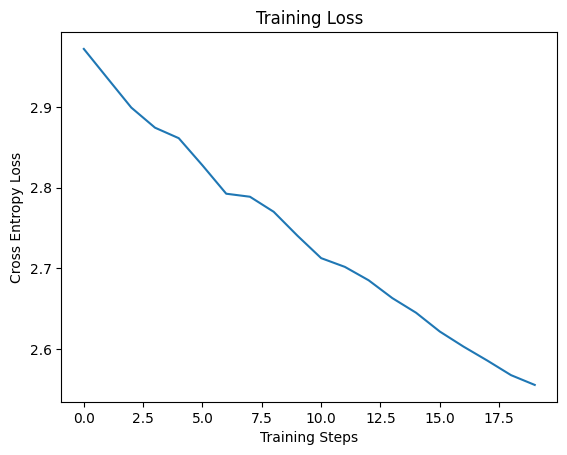

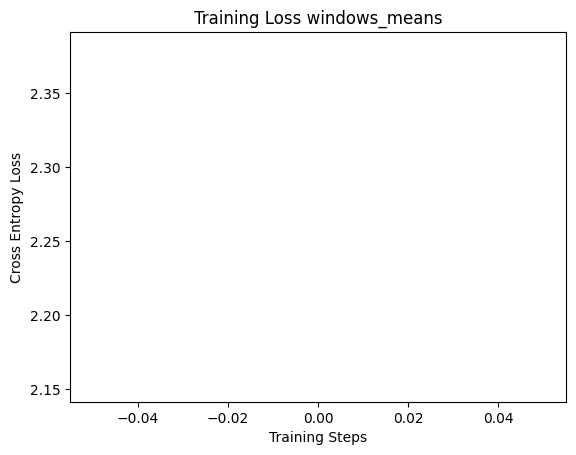

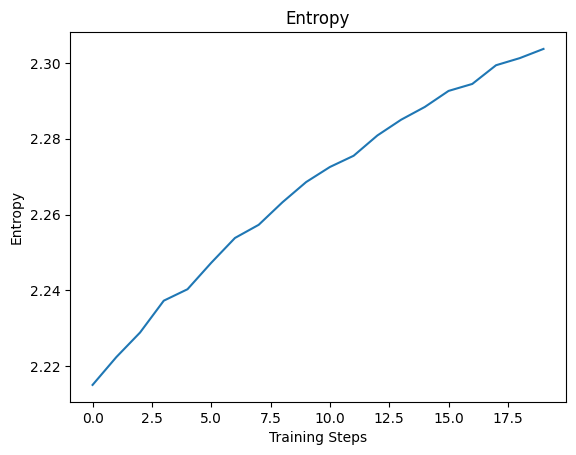

In [28]:
# torch.manual_seed(1)
if len(seq_token) > 10:
    input_tokens = seq_token[-10:]
else:
    input_tokens = seq_token
    
print(f"\033[0;32mLe prompt\033[0m {input_tokens}")
for i in input_tokens:
    print(tokenizer.decode(i))
print()

input_tokens = torch.tensor(input_tokens).reshape(1, -1)
log_tokens, data_pred, df = generate_sentence(lstm_generator, input_tokens, tokenizer=tokenizer)
df.to_csv("monitoring.csv", index=False)
interaction_pred = [tokenizer.decode(token.item()) for token in log_tokens if tokenizer.decode(token.item()) != "<pad>"]

actions, outcomes = run_token(log_tokens, env_test, "imgToGif2")
env_test.display_world()

good_pred = []
for i in range(len(interaction_pred)):
    good_pred.append(interaction_pred[i] == (actions[i], outcomes[i]))

# print(f"\033[0;32mLes vrai outcomes\033[0m \n{outcomes}")
# Create a DataFrame to store interactions, actions, and outcomes
df_interactions = pd.DataFrame({
    'Interaction générer': interaction_pred,
    'Action appliquer': actions,
    'Outcome réel': outcomes,
    'verifier': ['Correct' if i else 'Incorrect' for i in good_pred]
})

print("\033[0;32mDataFrame des interactions\033[0m")
print(df_interactions)
df_interactions.to_csv("interactions.csv", index=False)
print(f"\033[0;32mnombre de bonne prédiction : {sum(good_pred)} sur {len(good_pred)} et {len(log_tokens)} générer\033[0m")

all_actions += actions
all_outcomes += outcomes

seq_token += action_outcome_to_token(all_actions, all_outcomes)
print('seq token', seq_token)
print(f"Nombre d'interaction total : {len(seq_token)}")
data_set = CustomDataSetTextGenByToken(
    token=seq_token,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=20,
    min=10)

print(f"\033[0;32mtaille du jeu de donnée \033[0m{len(data_set)}")

data_loader_train = DataLoader(
        data_set,
        batch_size=64,
        shuffle=True,
        num_workers=8
    )

td = TokenDrop(prob=0.1, pad_token=tokenizer.encode("<pad>"), num_special=1)
training_loss_logger, entropy_logger = train(lstm_generator=lstm_generator, td=td,
                                            nb_epoch=20, optimizer=opti,loss_fn=loss_fct,
                                            data_loader_train=data_loader_train)

plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

windows_means = []
window_size = 100
for i in range(0, len(entropy_logger), window_size):
    windows_means.append(np.mean(entropy_logger[i:i + window_size]))
plt.plot(windows_means)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss windows_means')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()

In [29]:
raise "Fin de la première méthode"

TypeError: exceptions must derive from BaseException

## Résulats

Voir [monitoring.csv](./monitoring.csv) et [interactions.csv](./interactions.csv) pour plus de détail sur la dérnière application de la cellule

### Result
Au bout d'un certain nombre d'interactions, le modèle arrive a comprendre l'environement. Mais il essaye d'overfit et n'a aucune notion de valence. Cela n'empeche pas de voir des séquences courte d'interactions menant à forward, empty


### Old resulat
Première remarque, depuis le comportement a changer **TODO REMOVE**  
Avec cette première façon d'utiliser la génération de texte nous voyons que le modèle ne forme que deux séquence qui sont :  
1. turn_left, empty; turn_right, empty; **feel_front, wall; feel_front, wall**; turn_left, empty; forward, empty
2. turn_left, empty; turn_right, empty; **feel_front, wall; feel_front, empty**; turn_left, empty; forward, empty

On remarque que se sont les mêmes actions, le modèle change juste le token feel_front, wall pour eel_front, empty. Ce qui est logique car dans son jeu de train, il a les deux version de séquence. Mais au vue de sont trop petit jeu de données, le modèl ne peut pas créer d'autre séquence. Nous pouvons remarquer aussi que le modèl n'arrive pas a prédire quand il faut générer feel_front, wall ou feel_front, empty. Nous pouvons émetre l'hypothèse qu'un context lenght et/ou prompt plus grand permetrais de prédire corectement ces deux séquences.

# Autre environement
Notre environement actuel permet de répeter ces deux séquences sans avoir de variation. Mais que ce passerait t'il si l'environement n'était pas aussi simple ?

L'enironement du small loop (voir travaux d'Olivier Georgon).
```py
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 1, 1, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
```

En gardant le même context lenght et même longeur de prompt pour cet environement :
```py
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1, 0, 0, 0, 1],
                [1, 1, 1, 0, 1, 0, 1, 0, 1],
                [1, 0, 0, 0, 0, 0, 1, 0, 1],
                [1, 0, 1, 1, 1, 1, 0, 0, 1],
                [1, 0, 1, 1, 0, 0, 0, 1, 1],
                [1, 0, 0, 0, 0, 1, 1, 1, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1],
            ]))
```
Nous remarquons que le modèle tente beaucoup d'action pour arriver à l'interaction forward, empty. Mais même si cela dois générer un jeu de données plus complet, nous pouvons remarquer que le modèle n'a pas assez d'information pour traiter comme il faut l'environement. Il y a deux points a revoir dans cette boucle :
1. La taille du context lenght et du prompt, nous pouvons passer a 50, puis 100 en fonction des résulats
2. Générer petit a petit, si le modèl se trompe a un moment dans la séquence, la suite de ca génération ne devrais pas être bon. Pour pallier ce problème et essayer d'obtenir une meilleur compréhension de la par du modèle, nous pouvons faire l'action et remplacer par la vrai interaction.  

La boucle suivante va juste augmenter la taille du prompt et du context lenght, le code suivant cette boucle essayera la deuxième solution avec les résulats de la premirèe solution.

# Deuxième boucle
## Initialisation

In [ ]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1, 0, 0, 0, 1],
                [1, 1, 1, 0, 1, 0, 1, 0, 1],
                [1, 0, 0, 0, 0, 0, 1, 0, 1],
                [1, 0, 1, 1, 1, 1, 0, 0, 1],
                [1, 0, 1, 1, 0, 0, 0, 1, 1],
                [1, 0, 0, 0, 0, 1, 1, 1, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1],
            ]))

list_vocab = ['<pad>']
# Nous notons toutes les interactions techniquement possible
for act in env_test.get_actions():
    for fb in env_test.get_outcomes():
        list_vocab.append((act, fb))

# Nous pouvons suprimer des interactions qui ne sont en réalité pas possible.
list_vocab.remove(('turn_left', 'wall'))
list_vocab.remove(('turn_right', 'wall'))
for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)
tokenizer = SimpleTokenizerV1(vocab=tmp)

all_actions, all_outcomes = [], []
all_actions.append('forward') # Première action de base 
all_outcomes.append(env_test.outcome('forward')) # Première outcome de base
# Cette première interaction nous servira de premier prompt
seq_token = [tokenizer.encode((all_actions[0], all_outcomes[0]))]

env_test.display_world()

lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=16,
    emb_size=16,
    num_layers=2,
    dropout=0.1
)
opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss(ignore_index=tokenizer.encode("<pad>"))

SIZE_CONTEXT = 20
SIZE_PROMPT = SIZE_CONTEXT
SIZE_CONTEXT_MIN = 2
TEMPERATURE = 5.0
MAX_DATA_TRAINING = 300

## Vérification, action aléatoire jusqu'à forward empty

In [ ]:
while seq_token[-1] != tokenizer.encode(('forward', 'empty')):
    action_random = np.random.choice(env_test.get_actions())
    outcome_random = env_test.outcome(action_random)
    seq_token.append(tokenizer.encode((action_random, outcome_random)))
    
print(f"\033[0;32mLa séquence \033[0m")
print(tokenizer.decode(seq_token))
print(seq_token)
print('taille de la séquence aléatoire', len(seq_token))

## Execusion deuxième boucle

In [ ]:
TEMPERATURE = 5.0

if len(seq_token) > MAX_DATA_TRAINING:
    seq_to_data_set = seq_token[-SIZE_CONTEXT:]
else:
    seq_to_data_set = seq_token
data_set = CustomDataSetTextGenByToken(
    token=seq_to_data_set,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=SIZE_CONTEXT,
    min=SIZE_CONTEXT_MIN)

print(f"\033[0;32mtaille du jeu de donnée \033[0m{len(data_set)}")

data_loader_train = DataLoader(
        data_set,
        batch_size=1,
        shuffle=True,
        num_workers=8
    )

training_loss_logger, entropy_logger = train(
    lstm_generator=lstm_generator, data_loader_train=data_loader_train, nb_epoch=20, optimizer=opti, loss_fn=loss_fct, td=None)

plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

windows_means = []
window_size = 100
for i in range(0, len(entropy_logger), window_size):
    windows_means.append(np.mean(entropy_logger[i:i + window_size]))
plt.plot(windows_means)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss windows_means')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()

if len(seq_token) > SIZE_PROMPT:
    input_tokens = seq_token[-SIZE_PROMPT:]
else:
    input_tokens = seq_token
    
print(f"\033[0;32mLe prompt\033[0m {input_tokens}")
for i in input_tokens:
    print(tokenizer.decode(i))
print()

input_tokens = torch.tensor(input_tokens).reshape(1, -1)
log_tokens, data_pred, df = generate_sentence(lstm_generator=lstm_generator,
                                            input_tokens=input_tokens, tokenizer=tokenizer, temp=TEMPERATURE, max_len=20, end_token=tokenizer.encode(('forward', 'empty')))
df.to_csv("monitoring.csv", index=False)
interaction_pred = [tokenizer.decode(token.item()) for token in log_tokens if tokenizer.decode(token.item()) != "<pad>"]

actions, outcomes = run_token(log_tokens, env_test)
env_test.display_world()


good_pred = []
for i in range(len(interaction_pred)):
    good_pred.append(interaction_pred[i] == (actions[i], outcomes[i]))

# print(f"\033[0;32mLes vrai outcomes\033[0m \n{outcomes}")
# Create a DataFrame to store interactions, actions, and outcomes
df_interactions = pd.DataFrame({
    'Interaction générer': interaction_pred,
    'Action appliquer': actions,
    'Outcome réel': outcomes,
    'verifier': ['Correct' if i else 'Incorrect' for i in good_pred]
})

print("\033[0;32mDataFrame des interactions\033[0m")
print(df_interactions)
df_interactions.to_csv("interactions.csv", index=False)
print(f"\033[0;32mnombre de bonne prédiction : {sum(good_pred)} sur {len(good_pred)} et {len(log_tokens)} générer\033[0m")

all_actions += actions
all_outcomes += outcomes

seq_token += action_outcome_to_token(all_actions, all_outcomes)
print('seq token', seq_token)
print(f"Nombre d'interaction total : {len(seq_token)}")

In [ ]:
# Juste de la génération
if len(seq_token) > SIZE_PROMPT:
    input_tokens = seq_token[-SIZE_PROMPT:]
else:
    input_tokens = seq_token
    
print(f"\033[0;32mLe prompt\033[0m {input_tokens}")
for i in input_tokens:
    print(tokenizer.decode(i))
print()

input_tokens = torch.tensor(input_tokens).reshape(1, -1)
log_tokens, data_pred, df = generate_sentence(lstm_generator=lstm_generator,
                                            input_tokens=input_tokens, tokenizer=tokenizer, temp=TEMPERATURE)
df.to_csv("monitoring.csv", index=False)
interaction_pred = [tokenizer.decode(token.item()) for token in log_tokens if tokenizer.decode(token.item()) != "<pad>"]
# print("\033[0;32m Génération du modèle :\033[0m")
# for i in log_tokens:
#     print(tokenizer.decode(i.item()))

actions, outcomes = run_token(log_tokens, env_test)
env_test.display_world()

good_pred = []
for i in range(len(interaction_pred)):
    good_pred.append(interaction_pred[i] == (actions[i], outcomes[i]))

# print(f"\033[0;32mLes vrai outcomes\033[0m \n{outcomes}")
# Create a DataFrame to store interactions, actions, and outcomes
df_interactions = pd.DataFrame({
    'Interaction générer': interaction_pred,
    'Action appliquer': actions,
    'Outcome réel': outcomes,
    'verifier': ['Correct' if i else 'Incorrect' for i in good_pred]
})

print("\033[0;32mDataFrame des interactions\033[0m")
print(df_interactions)
df_interactions.to_csv("interactions.csv", index=False)
print(f"\033[0;32mnombre de bonne prédiction : {sum(good_pred)} sur {len(good_pred)} et {len(log_tokens)} générer\033[0m")

all_actions += actions
all_outcomes += outcomes

seq_token += action_outcome_to_token(all_actions, all_outcomes)
print('seq token', seq_token)

## Resultat
Voir les [probabilités de chaque intérations](./monitoring.csv) et [l'application sur l'environement](./interactions.csv) de la dernière cellule éxecuter.
Le modèl finit pat boucler sur une séquence d'interaction.

### Prompt 1
```txt
Le prompt [4, 2, 2, 7, 4, 7, 4, 2, 2, 7, 4, 7, 4, 2, 2, 7, 4, 7, 4, 2]
('turn_right', 'empty')
('forward', 'empty')
('forward', 'empty')
('feel_left', 'wall')
('turn_right', 'empty')
('feel_left', 'wall')
('turn_right', 'empty')
('forward', 'empty')
('forward', 'empty')
('feel_left', 'wall')
('turn_right', 'empty')
('feel_left', 'wall')
('turn_right', 'empty')
('forward', 'empty')
('forward', 'empty')
('feel_left', 'wall')
('turn_right', 'empty')
('feel_left', 'wall')
('turn_right', 'empty')
('forward', 'empty')
```

| \<pad\> | ('forward', 'wall') | ('forward', 'empty') | ('turn_left', 'empty') | ('turn_right', 'empty') | ('feel_front', 'wall') | ('feel_front', 'empty') | ('feel_left', 'wall') | ('feel_left', 'empty') | ('feel_right', 'wall') | ('feel_right', 'empty') | interactions choisies |
| ----- | ------------------- | -------------------- | ---------------------- | ----------------------- | ---------------------- | ----------------------- | --------------------- | ---------------------- | ---------------------- | ----------------------- | --------------------- |
| 0.0   | 0.0                 | 0.982                | 0.0                    | 0.0                     | 0.0                    | 0.0                     | 0.018                 | 0.0                    | 0.0                    | 0.0                     | ('forward', 'empty')  |
|       |                     |                      |                        |                         |                        |                         |                       |                        |                        |                         |                       |

### Prompt 2
```txt
Le prompt [2, 2, 7, 4, 7, 4, 2, 2, 7, 4, 7, 4, 2, 2, 7, 4, 7, 4, 2, 2]
('forward', 'empty')
('forward', 'empty')
('feel_left', 'wall')
('turn_right', 'empty')
('feel_left', 'wall')
('turn_right', 'empty')
('forward', 'empty')
('forward', 'empty')
('feel_left', 'wall')
('turn_right', 'empty')
('feel_left', 'wall')
('turn_right', 'empty')
('forward', 'empty')
('forward', 'empty')
('feel_left', 'wall')
('turn_right', 'empty')
('feel_left', 'wall')
('turn_right', 'empty')
('forward', 'empty')
('forward', 'empty')
```

| <pad> | ('forward', 'wall') | ('forward', 'empty') | ('turn_left', 'empty') | ('turn_right', 'empty') | ('feel_front', 'wall') | ('feel_front', 'empty') | ('feel_left', 'wall') | ('feel_left', 'empty') | ('feel_right', 'wall') | ('feel_right', 'empty') | interactions choisies   |
| ----- | ------------------- | -------------------- | ---------------------- | ----------------------- | ---------------------- | ----------------------- | --------------------- | ---------------------- | ---------------------- | ----------------------- | ----------------------- |
| 0.0   | 0.037               | 0.227                | 0.0                    | 0.0                     | 0.0                    | 0.0                     | 0.736                 | 0.0                    | 0.0                    | 0.0                     | ('feel_left', 'wall')   |
| 0.0   | 0.0                 | 0.0                  | 0.0                    | 1.0                     | 0.0                    | 0.0                     | 0.0                   | 0.0                    | 0.0                    | 0.0                     | ('turn_right', 'empty') |
| 0.0   | 0.0                 | 0.0                  | 0.0                    | 0.0                     | 0.0                    | 0.0                     | 1.0                   | 0.0                    | 0.0                    | 0.0                     | ('feel_left', 'wall')   |
| 0.0   | 0.0                 | 0.0                  | 0.0                    | 1.0                     | 0.0                    | 0.0                     | 0.0                   | 0.0                    | 0.0                    | 0.0                     | ('turn_right', 'empty') |
| 0.0   | 0.0                 | 1.0                  | 0.0                    | 0.0                     | 0.0                    | 0.0                     | 0.0                   | 0.0                    | 0.0                    | 0.0                     | ('forward', 'empty')    |
|       |                     |                      |                        |                         |                        |                         |                       |                        |                        |                         |                         |

### Répétition ?
La séquence qui se répète est la suivante :  
('feel_left', 'wall') | ('turn_right', 'empty') | ('feel_left', 'wall') | ('turn_right', 'empty') | ('forward', 'empty') | ('forward', 'empty')  
Nous ne pouvons pas dire que le modèle "comprenne" l'environement, il ne fait que répéter en boucle une séquence possible.

### old Résultat
Ancian résulat

DataFrame des interactions
| Interaction (Action, Perception) | Action appliquée | Outcome réel | Vérification |
|----------------------------------|------------------|--------------|-------------|
| (forward, wall)                  | forward          | wall         | Correct     |
| (feel_left, wall)                | feel_left        | empty        | Incorrect   |
| (turn_right, empty)              | turn_right       | empty        | Correct     |
| (feel_front, wall)               | feel_front       | wall         | Correct     |
| (turn_left, empty)               | turn_left        | empty        | Correct     |
| (forward, empty)                 | forward          | wall         | Incorrect   |

Avec ces intérations proposé par le modèl, nous ne pouvons savoir si il a compris l'environement et ces actions. Mais il est a noté que nous ne voulons pas forcément déviner les interactions de feel. Nous voulons que le modèle s'en servent pour trouver une séquence menant a forward Empty. Ce qui me ramène a la deuxième solution, corigé en pendant la génération.

## Variation de la génération
Pandant que le modèl génére une phrase (qui est cencé être cohérant avec l'environement) il se peut qu'il se trompe. Sauf que cela implique potentielement que toutes la suite de la génération se base sur une mauvaise intéraction. Pour éviter qu'à la moindre erreur tout deviennent faux, je propose une modification sur la fonction de génération. A la place de donner systématiquement le mot généré, nous prennons l'action du token générer et nous l'appliquons dans l'environement. Ainsi nous avons une séquence correct sur l'environement.

In [ ]:
def generate_sentence_with_env(lstm_generator:nn.Module, input_tokens:torch.Tensor, env_apply:env, tokenizer:SimpleTokenizerV1, temp:int=1.0, max_len:int=50, end_token:int|None=2, path:str|None=None):
    """Generate a sequence of tokens using the LSTM generator and apply them to the environment.
    Args:
        lstm_generator (nn.Module): The LSTM generator model.
        input_tokens (torch.Tensor): The input tokens to start the generation.
        env_apply (env): The environment to apply the actions.
        tokenizer (SimpleTokenizerV1): The tokenizer to decode the tokens.
        temp (int, optional): Temperature for sampling. Defaults to 1.0.
        max_len (int, optional): Maximum length of the generated sequence. Defaults to 50.
        end_token (int|None, optional): Token indicating the end of the sequence. Defaults to 2.
        path (str|None, optional): Path to save the environment state. Defaults to None.
    Returns:
        list: The generated tokens.
        torch.Tensor: The last prediction from the LSTM generator.
        pd.DataFrame: DataFrame containing the interactions, actions, outcomes, and correctness.
    """
    lstm_generator.eval()
    log_tokens = []
    # Disable gradient calculation
    with torch.no_grad():
        # Initialize hidden and memory states
        hidden = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)
        memory = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)

        # Monitor number of good and bad predictions
        good = []
        actions = []
        outcomes = []
        pred_out_list = []
        generation_special_token = 0
        probability = {}
        for i in range(tokenizer.size_vocab):
            probability[tokenizer.decode(i)] = []
            
        for i in range(max_len): # On met une limite de 100 tokens
            # Forward pass through LSTM generator
            data_pred, hidden, memory = lstm_generator(input_tokens, hidden, memory)

            # Sample from the distribution of probabilities (with temperature)
            dist = Categorical(logits=data_pred[:, -1] / temp)
            input_tokens = dist.sample().reshape(1, 1)
            
            if tokenizer.decode(input_tokens.item()) not in ["<pad>"]: # Vérifier que le token n'est pas un padding ou token spécial
                pred_out = tokenizer.decode(input_tokens.item())[1]
                real_out = env_apply.outcome(tokenizer.decode(input_tokens.item())[0])
                env_apply.save_world(path="imgToGif2")
                input_tokens = torch.tensor(tokenizer.encode((tokenizer.decode(input_tokens.item())[0], real_out))).reshape(1, -1)
                good.append(real_out == pred_out)
                actions.append(tokenizer.decode(input_tokens.item())[0])
                outcomes.append(real_out)
                pred_out_list.append(pred_out)
                proba_tmp = F.softmax(data_pred/temp, -1).cpu().numpy().flatten()
                for i in range(tokenizer.size_vocab):
                    probability[tokenizer.decode(i)].append(round(float(proba_tmp[i]), 3))
                    
                if path is not None:
                    env_apply.save_world(path=path)
            else:
                generation_special_token += 1

            # Append generated token to log_tokens
            log_tokens.append(input_tokens.cpu())
            
            # Check for end-of-sentence token
            if input_tokens.item() == end_token:
                break
    tmp = probability
    tmp.update({'Action': actions,
        'Prediciton': pred_out_list,
        'Outcome Réel': outcomes,
        'verifier': ['Correct' if i else 'Incorrect' for i in good]})
    df_interactions = pd.DataFrame(tmp, index=range(1, len(good) + 1))
    print(f'nb de génération {len(log_tokens)}')
    print(f'nb de bonne prédiction {sum(good)} sur {len(good)} nombre de spécial token {generation_special_token}')
    return log_tokens, data_pred, df_interactions

# Autre boucle

In [ ]:
# torch.manual_seed(1)
# Historique des actions et outcomes
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1, 0, 0, 0, 1],
                [1, 1, 1, 0, 1, 0, 1, 0, 1],
                [1, 0, 0, 0, 0, 0, 1, 0, 1],
                [1, 0, 1, 1, 1, 1, 0, 0, 1],
                [1, 0, 1, 1, 0, 0, 0, 1, 1],
                [1, 0, 0, 0, 0, 1, 1, 1, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1],
            ]))

list_vocab = ['<pad>']
# Nous notons toutes les interactions techniquement possible
for act in env_test.get_actions():
    for fb in env_test.get_outcomes():
        list_vocab.append((act, fb))

# Nous pouvons suprimer des interactions qui ne sont en réalité pas possible.
list_vocab.remove(('turn_left', 'wall'))
list_vocab.remove(('turn_right', 'wall'))
for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)
tokenizer = SimpleTokenizerV1(vocab=tmp)

all_actions, all_outcomes = [], []
all_actions.append('forward') # Première action de base 
all_outcomes.append(env_test.outcome('forward')) # Première outcome de base
# Cette première interaction nous servira de premier prompt
seq_token = [tokenizer.encode((all_actions[0], all_outcomes[0]))]

env_test.display_world()

lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=16,
    emb_size=16,
    num_layers=2,
    dropout=0.1
)
opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss(ignore_index=tokenizer.encode("<pad>"))

In [ ]:
# np.random.seed(2)
SIZE_CONTEXT = 20
SIZE_PROMPT = SIZE_CONTEXT
SIZE_CONTEXT_MIN = 10

i = 0
while i < SIZE_CONTEXT or seq_token[-1] != tokenizer.encode(('forward', 'empty')):
    i += 1
    action_random = np.random.choice(env_test.get_actions())
    outcome_random = env_test.outcome(action_random)
    seq_token.append(tokenizer.encode((action_random, outcome_random)))
    
print(f"\033[0;32mLa séquence \033[0m")
print(tokenizer.decode(seq_token))
print(seq_token)
print('taille de la séquence aléatoire', len(seq_token))

In [ ]:
# torch.manual_seed(1)
if len(seq_token) > SIZE_PROMPT:
    input_tokens = seq_token[-SIZE_PROMPT:]
else:
    input_tokens = seq_token
    
print(f"\033[0;32mLe prompt\033[0m {input_tokens}")
for i in input_tokens:
    print(tokenizer.decode(i))
print()

input_tokens = torch.tensor(input_tokens).reshape(1, -1)
log_tokens, data_pred, df_interactions = generate_sentence_with_env(
    lstm_generator=lstm_generator, input_tokens=input_tokens, env_apply=env_test, 
    tokenizer=tokenizer, temp=1.0, path="imgToGif2", max_len=30, end_token=tokenizer.encode(('forward', 'empty'))
)
df_interactions.to_csv("interactions.csv", index=False)

interaction_pred = [token.item() for token in log_tokens if tokenizer.decode(token.item()) != "<pad>"]
seq_token += interaction_pred

print('seq token', seq_token)
print(f"Nombre d'interaction total : {len(seq_token)}")
data_set = CustomDataSetTextGenByTokenV2(
    token=seq_token,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=SIZE_CONTEXT,
    min=SIZE_CONTEXT_MIN)

print(f"\033[0;32mtaille du jeu de donnée \033[0m{len(data_set)}")

data_loader_train = DataLoader(
        data_set,
        batch_size=1,
        shuffle=True,
        num_workers=8
    )

td = TokenDrop(prob=0.1, pad_token=tokenizer.encode("<pad>"), num_special=1)
training_loss_logger, entropy_logger = train(lstm_generator=lstm_generator, data_loader_train=data_loader_train,
                                            nb_epoch=20, optimizer=opti, loss_fn=loss_fct, td=td)

plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

windows_means = []
window_size = 100
for i in range(0, len(entropy_logger), window_size):
    windows_means.append(np.mean(entropy_logger[i:i + window_size]))
plt.plot(windows_means)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss windows_means')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training S_with_envteps')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()

# Résultat
Le modèle est très bon, mais il n'arrive pas à trouver de séquence qui amène a l'interaction voulut.


# Train
Pour l'instant je n'utilise pas le pad. Je triche en obligant une certain de taille lors du train. Modifions la fonction de train pour calculer la loss que sur les vrai token

In [ ]:
# Fonction non utilisé, non vraiment tester
def train_without_pad(lstm_generator, nb_epoch:int, optimizer, loss_fn, td:TokenDrop|None):
    # Monitor training loss and entropy
    training_loss_logger = []
    entropy_logger = []

    for _ in tqdm(range(nb_epoch)):
        # Set LSTM generator model to training mode
        lstm_generator.train()
        # Iterate over batches in training data loader
        for text in tqdm(data_loader_train, desc="Training", leave=False):
            # Transform text tokens using training transform and move to device
            bs = text.shape[0]
            
            # Randomly drop input tokens
            if td is not None:
                input_text = td(text[:, 0:-1])
            else:
                input_text = text[:, 0:-1]
            output_text = text[:, 1:]
            mask = (output_text != tokenizer.encode("<pad>")).float()
            
            # Or not drop tokens
            # input_text = text[:, 0:-1]
            # output_text = text[:, 1:]
            
            # Initialize the memory buffers
            hidden = torch.zeros(lstm_generator.num_layers, bs, lstm_generator.hidden_size)
            memory = torch.zeros(lstm_generator.num_layers, bs, lstm_generator.hidden_size)
            
            # Forward pass through the LSTM generator
            pred, hidden, memory = lstm_generator(input_text, hidden, memory)

            # Calculate loss
            loss = loss_fn(pred.transpose(1, 2), output_text) * mask
            loss = loss.sum() / mask.sum()
            
            # Zero gradients, perform backward pass, and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Log training loss
            training_loss_logger.append(loss.item())
            
            # Log entropy during training (for monitoring)
            with torch.no_grad():
                dist = Categorical(logits=pred)
                entropy_logger.append(dist.entropy().mean().item())
    return training_loss_logger, entropy_logger

In [ ]:
# torch.manual_seed(1)
# Historique des actions et outcomes
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1, 0, 0, 0, 1],
                [1, 1, 1, 0, 1, 0, 1, 0, 1],
                [1, 0, 0, 0, 0, 0, 1, 0, 1],
                [1, 0, 1, 1, 1, 1, 0, 0, 1],
                [1, 0, 1, 1, 0, 0, 0, 1, 1],
                [1, 0, 0, 0, 0, 1, 1, 1, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1],
            ]))

list_vocab = ['<pad>']
# Nous notons toutes les interactions techniquement possible
for act in env_test.get_actions():
    for fb in env_test.get_outcomes():
        list_vocab.append((act, fb))

# Nous pouvons suprimer des interactions qui ne sont en réalité pas possible.
list_vocab.remove(('turn_left', 'wall'))
list_vocab.remove(('turn_right', 'wall'))
for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)
tokenizer = SimpleTokenizerV1(vocab=tmp)

all_actions, all_outcomes = [], []
all_actions.append('forward') # Première action de base 
all_outcomes.append(env_test.outcome('forward')) # Première outcome de base
# Cette première interaction nous servira de premier prompt
seq_token = [tokenizer.encode((all_actions[0], all_outcomes[0]))]

env_test.display_world()

lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=16,
    emb_size=16,
    num_layers=2,
    dropout=0.1
)
opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss(ignore_index=tokenizer.encode("<pad>")) # Ajout de ignore_index pour ne pas prendre en compte le padding

In [ ]:
# np.random.seed(2)
SIZE_CONTEXT = 10
SIZE_CONTEXT_MIN = 5
SIZE_PROMPT = SIZE_CONTEXT
TEMPERATURE = 10

i = 0
while i < SIZE_CONTEXT_MIN or seq_token[-1] != tokenizer.encode(('forward', 'empty')):
    i += 1
    action_random = np.random.choice(env_test.get_actions())
    outcome_random = env_test.outcome(action_random)
    env_test.save_world(path="imgToGif2")
    seq_token.append(tokenizer.encode((action_random, outcome_random)))
    
print(f"\033[0;32mLa séquence \033[0m")
print(tokenizer.decode(seq_token))
print(seq_token)
print('taille de la séquence aléatoire', len(seq_token))

In [ ]:
# torch.manual_seed(1)
if len(seq_token) > SIZE_PROMPT:
    input_tokens = seq_token[-SIZE_PROMPT:]
else:
    input_tokens = seq_token
    
print(f"\033[0;32mLe prompt\033[0m {input_tokens}")
for i in input_tokens:
    print(tokenizer.decode(i))
print()

input_tokens = torch.tensor(input_tokens).reshape(1, -1)
log_tokens, data_pred, df_interactions = generate_sentence_with_env(lstm_generator, input_tokens, env_test, tokenizer, 1)
interaction_pred = [tokenizer.decode(token.item()) for token in log_tokens if tokenizer.decode(token.item()) != "<pad>"]
# save dataframe
df_interactions.to_csv("interactions.csv", index=False)

no_pad = [token.item() for token in log_tokens if token.item() != tokenizer.encode("<pad>")]
print(no_pad)
seq_token += no_pad

print('seq token', seq_token)
data_set = CustomDataSetTextGenByToken(
    token=seq_token,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=SIZE_CONTEXT,
    min=SIZE_CONTEXT_MIN)

print(f"\033[0;32mtaille du jeu de donnée \033[0m{len(data_set)}")

data_loader_train = DataLoader(
        data_set,
        batch_size=32,
        shuffle=True,
        num_workers=8
    )

td = TokenDrop(prob=0.1, pad_token=tokenizer.encode("<pad>"), num_special=1)
training_loss_logger, entropy_logger = train(lstm_generator=lstm_generator,data_loader_train=data_loader_train, nb_epoch=20,
                                             optimizer=opti, loss_fn=loss_fct, td=td)

plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

windows_means = []
window_size = 100
for i in range(0, len(entropy_logger), window_size):
    windows_means.append(np.mean(entropy_logger[i:i + window_size]))
plt.plot(windows_means)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss windows_means')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()

# Résulat
Avec context lenght de 50 et min de 10, PROMPt de 50, le modèle finit (rapidement <50 itération) par donner des séquences d'une dizaine d'itérations. Ces prédictions sont très largement bonnes, il ne se trompe que rarement. Les actions éfféctuer ne sont pas forcément cohérente (turn right suivit de turn left).

Voir :

![gif](./gentText.gif)  

ou la vidéo  

![movie](./generationTexte.mp4)

## Vérifier les connaissances du model
Pour vérifier si le modèl est bon ou non, nous pouvons le faire générer un grand nombre d'intéractions (1000) et les faire pas à pas. Pour au final voir si il arrive a toujours prédire de bonne intéraction

In [ ]:
def verify(lstm_generator, input_tokens, env_apply, temp:int=1.0):
    lstm_generator.eval()
    log_tokens = []
    # Disable gradient calculation
    with torch.no_grad():
        # Initialize hidden and memory states
        hidden = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)
        memory = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)

        # Monitor number of good and bad predictions
        good = []
        actions = []
        outcomes = []
        pred_out_list = []
        generation_special_token = 0
        for i in range(1000): # On met une limite de 100 tokens
            # Forward pass through LSTM generator
            data_pred, hidden, memory = lstm_generator(input_tokens, hidden, memory)

            # Sample from the distribution of probabilities (with temperature)
            dist = Categorical(logits=data_pred[:, -1] / temp)
            input_tokens = dist.sample().reshape(1, 1)
            
            if tokenizer.decode(input_tokens.item()) not in ["<pad>"]: # Vérifier que le token n'est pas un padding ou token spécial
                pred_out = tokenizer.decode(input_tokens.item())[1]
                real_out = env_apply.outcome(tokenizer.decode(input_tokens.item())[0])
                env_apply.save_world(path="imgToGif2")
                input_tokens = torch.tensor(tokenizer.encode((tokenizer.decode(input_tokens.item())[0], real_out))).reshape(1, -1)
                good.append(real_out == pred_out)
                actions.append(tokenizer.decode(input_tokens.item())[0])
                outcomes.append(real_out)
                pred_out_list.append(pred_out)
            else:
                generation_special_token += 1

            # Append generated token to log_tokens
            log_tokens.append(input_tokens.cpu())
            
    df_interactions = pd.DataFrame({
        'Action': actions,
        'Prediciton': pred_out_list,
        'Outcome Réel': outcomes,
        'verifier': ['Correct' if i else 'Incorrect' for i in good]
    })
    # print(f'nb de génération {len(log_tokens)}')
    print(f'nb de bonne prédiction {sum(good)} sur {len(good)} nombre de spécial token {generation_special_token}')
    return log_tokens, data_pred, df_interactions

In [ ]:
input_tokens = seq_token[-SIZE_PROMPT:]
input_tokens = torch.tensor(input_tokens).reshape(1, -1)
log_tokens, data_pred, df_interactions = verify(lstm_generator, input_tokens, env_test, temp=0.1)
df_interactions.to_csv("interactions.csv", index=False)

## Accuracy
nb de bonne prédiction 948 sur 1000 nombre de spécial token 0. Donc 95% d'accuracie
## Mais ?
Voici la séquence que le modèl répète en boucle :
![gif](./Verify.gif)

On ne peut pas dire que le modèle a compris son environement. Il a juste réussit à faire une séquence de manière sûr.

# END

In [ ]:
actions = ['forward']
outcomes = [env_test.outcome('forward')]
seq_token = tokenizer.encode([(actions[-1], outcomes[-1])])
print(seq_token)
lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=16,
    emb_size=16,
    num_layers=num_layers,
    dropout=0.1
)
opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss()

In [ ]:
input_tokens = seq_token[-10:]
print(f"\033[0;32mLe prompt\033[0m {input_tokens}")
for i in input_tokens:
    print(tokenizer.decode(i))
print()
env_test.display_world()
input_tokens_tok = torch.tensor(input_tokens).reshape(1, -1)
log_tokens, data_pred = generate_sentence_with_env(lstm_generator, input_tokens_tok, env_test, tokenizer)
# print("\033[0;32m Génération du modèle :\033[0m")
# for i in log_tokens:
#     print(tokenizer.decode(i.item()))

print('test mm')
no_pad = [token.item() for token in log_tokens if token.item() != tokenizer.encode("<pad>")]
print([tokenizer.decode(i) for i in no_pad])
print('size compute : ', len(log_tokens))

seq_token += no_pad
data_set = CustomDataSetTextGenByToken(
    token=seq_token,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=21,
    min=21)

print(f"\033[0;32mtaille du jeu de donnée \033[0m{len(data_set)}")

data_loader_train = DataLoader(
        data_set,
        batch_size=1,
        shuffle=True,
        num_workers=8
    )

td = TokenDrop(prob=0.1, pad_token=tokenizer.encode("<pad>"), num_special=1)
training_loss_logger, entropy_logger = train(lstm_generator, 20, opti, loss_fct, td)

plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()

In [ ]:
raise Exception("Fin du programme")

# Training loss
On peut se rendre compte que le modèle n'arrive pas a s'entrainner de cette manière.

In [ ]:
# def generate_sentence_with_env(lstm_generator, input_tokens, env_apply):
#     lstm_generator.eval()
#     log_tokens = []
#     # Disable gradient calculation
#     with torch.no_grad():
#         # Initialize hidden and memory states
#         hidden = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)
#         memory = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)

#         # Generate text
#         good = 0
#         bad = 0
#         for i in range(100): # On met une limite de 100 tokens
#             # Forward pass through LSTM generator
#             data_pred, hidden, memory = lstm_generator(input_tokens, hidden, memory)

#             # Sample from the distribution of probabilities (with temperature)
#             dist = Categorical(logits=data_pred[:, -1] / temp)
#             input_tokens = dist.sample().reshape(1, 1)
            
#             if input_tokens.item() != tokenizer.encode("<pad>"):
#                 pred_out = tokenizer.decode(input_tokens.item())[1]
#                 real_out = env_apply.outcome(tokenizer.decode(input_tokens.item())[0])
#                 input_tokens = torch.tensor(tokenizer.encode((tokenizer.decode(input_tokens.item())[0], real_out))).reshape(1, -1)
#                 if real_out == pred_out:
#                     good += 1
#                 else:
#                     bad += 1
               

#             # Append generated token to log_tokens
#             log_tokens.append(input_tokens.cpu())
            
#             # Check for end-of-sentence token
#             if input_tokens.item() == tokenizer.encode(('forward', 'empty')): # Si le token est ('forward', 'empty') on s'arrête
#                 break
#         print(f"good : {good} bad : {bad}")
#     return log_tokens, data_pred

In [ ]:
print(input_tokens)
generate_sentence_with_env(lstm_generator, input_tokens, env_test)

In [ ]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

all_actions, all_outcomes = [], []
actions = ['forward']
outcomes = [env_test.outcome('forward')]
opti = optim.Adam(lstm_generator.parameters(), lr=0.0001)
loss_fct = nn.CrossEntropyLoss()
lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=32,
    emb_size=32,
    num_layers=num_layers,
    dropout=0.25
)
td = TokenDrop(prob=0.1, pad_token=tokenizer.encode("<pad>"), num_special=1)
seq_token = [tokenizer.encode(('forward', outcomes[-1]))]

In [ ]:
lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=16,
    emb_size=16,
    num_layers=num_layers,
    dropout=0.1
)
opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss()


In [ ]:
if len(seq_token) >= 10:
    input_tokens = seq_token[-10:]
else:
    input_tokens = seq_token
    
print(f"\033[0;32mLe prompt\033[0m {input_tokens}")
for i in input_tokens:
    print(tokenizer.decode(i))
print()
env_test.display_world()
input_tokens_tensor = torch.tensor(input_tokens).reshape(1, -1)
log_tokens, data_pred = generate_sentence_with_env(lstm_generator, input_tokens_tensor, env_test, tokenizer)

print([tokenizer.decode(i.item()) for i in log_tokens])

seq_token += [i.item() for i in log_tokens if i.item() != tokenizer.encode("<pad>")]
data_set = CustomDataSetTextGenByToken(
    token=seq_token,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=11,
    min=11)

print(f"\033[0;32mtaille du jeu de donnée \033[0m{len(data_set)}")

data_loader_train = DataLoader(
        data_set,
        batch_size=1,
        shuffle=True,
        num_workers=8
    )

training_loss_logger, entropy_logger = train(lstm_generator, 20, opti, loss_fct, td)

plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()

In [ ]:
for i in data_loader_train:
    print(i)

# Autre idée

In [ ]:
# Not use interaction token

In [ ]:
def generate_sentence_no_end(lstm_generator, input_tokens):
    lstm_generator.eval()
    log_tokens = []
    # Disable gradient calculation
    with torch.no_grad():
        # Initialize hidden and memory states
        hidden = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)
        memory = torch.zeros(lstm_generator.num_layers, 1, lstm_generator.hidden_size)

        # Generate text
        for i in range(20): # On met une limite de 100 tokens
            # Forward pass through LSTM generator
            data_pred, hidden, memory = lstm_generator(input_tokens, hidden, memory)

            # Sample from the distribution of probabilities (with temperature)
            dist = Categorical(logits=data_pred[:, -1] / temp)
            input_tokens = dist.sample().reshape(1, 1)

            # Append generated token to log_tokens
            log_tokens.append(input_tokens.cpu())

            # Check for end-of-sentence token
            # if input_tokens.item() == end_token:
            #     break
    return log_tokens, data_pred

In [ ]:
list_vocab = ['<pad>']
for act in env_test.get_actions():
    list_vocab.append(act)

for fb in env_test.get_outcomes():
    list_vocab.append(fb)

for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)
tokenizer = SimpleTokenizerV1(vocab=tmp)

In [ ]:
# Historique des actions et outcomes
all_actions, all_outcomes = [], []
actions = ['forward']
outcomes = [env_test.outcome('forward')]
opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss()
lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=16,
    emb_size=16,
    num_layers=num_layers,
    dropout=0.1
)


In [ ]:
class dataSetActFb(Dataset):
    def __init__(self, actions, outcomes, context_lenght, min, id_pad, tokenizer):
        self.actions = actions
        self.outcomes = outcomes
        self.tokenizer = tokenizer
        self.context_lenght = context_lenght
        self.min = min
        self.padding = id_pad
        self.data = self.create_data()
    
    def create_data(self):
        """
        Create the data
        """
        interaction = []
        for i in range(len(self.actions)):
            interaction += self.tokenizer.encode([self.actions[i], self.outcomes[i]])
        print("first debug")
        print(interaction)
        
        sentences = []
        for range_cut in range(self.min, self.context_lenght +1):
            for i in range(0, len(interaction) + 1 - range_cut, 1):
                sentences.append(interaction[i:i + range_cut])
                sentences[-1] = sentences[-1] + \
                                [self.padding] * (self.context_lenght - len(sentences[-1]))
        if len(sentences) == 0:
            sentences = [interaction + [self.padding] * (self.context_lenght - len(interaction))]
        
        print("debug")
        print(sentences)
        return sentences
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx])

In [ ]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

actions, outcomes = [], []

for i in range(100):
    actions.append(str(np.random.choice(env_test.get_actions())))
    outcomes.append(env_test.outcome(actions[-1]))


In [ ]:
# Train 
data_set = dataSetActFb(
    actions=actions,
    outcomes=outcomes,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=50,
    min=49,
    tokenizer=tokenizer)

print(f"\033[0;32mtaille du jeu de donnée \033[0m{len(data_set)}")

data_loader_train = DataLoader(
        data_set,
        batch_size=1,
        shuffle=True,
        num_workers=8
    )

td = TokenDrop(prob=0.1, pad_token=tokenizer.encode("<pad>"), num_special=1)
training_loss_logger, entropy_logger = train(lstm_generator, 20, opti, loss_fct, td)

plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()

In [ ]:
from environnement.environnement3Str import Environnement3

env_test = Environnement3()
print(env_test.outcome('a'))
print(env_test.outcome('b'))

actions, outcomes = [], []
for i in range(100):
    actions.append(str(np.random.choice(env_test.get_actions())))
    outcomes.append(env_test.outcome(actions[-1]))
    
tokenizer = SimpleTokenizerV1(vocab={'<pad>': 0, 'a': 1, 'b': 2, 'x': 3, 'y': 4})

In [ ]:
# Train
data_set = dataSetActFb(
    actions=actions,
    outcomes=outcomes,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=50,
    min=49,
    tokenizer=tokenizer)

print(f"\033[0;32mtaille du jeu de donnée \033[0m{len(data_set)}")

data_loader_train = DataLoader(
        data_set,
        batch_size=1,
        shuffle=True,
        num_workers=8
    )

lstm_generator = LSTM_GenText(
    num_emb=tokenizer.size_vocab,
    hidden_size=16,
    emb_size=16,
    num_layers=2,
    dropout=0.1
)
    

opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss()
td = TokenDrop(prob=0.1, pad_token=tokenizer.encode("<pad>"), num_special=1)
training_loss_logger, entropy_logger = train(lstm_generator, 20, opti, loss_fct, td)

plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()

In [ ]:
raise NotImplementedError
print(f"\033[0;32mLe prompt\033[0m {input_tokens}")
for i in input_tokens:
    print(tokenizer.decode(i))
print()
env_test.display_world()
input_tokens = torch.tensor(input_tokens).reshape(1, -1)
log_tokens, data_pred = generate_sentence_no_end(lstm_generator, input_tokens)
print("\033[0;32m Génération du modèle :\033[0m")
for i in log_tokens:
    print(tokenizer.decode(i.item()))

actions, outcomes = run_token(log_tokens, env_test)
print(f"\033[0;32mLes vrai outcomes\033[0m \n{outcomes}")
all_actions += actions
all_outcomes += outcomes

seq_token = action_outcome_to_token(all_actions, all_outcomes)


In [ ]:
raise Exception
# Je vais considérer que nous avons une seul séquence (ce qui est en soit le cas)
# Pour l'entrainement je vais cacher certain token de la séquence et demander au modèle de les prédire
# Je vais ensuite comparer les prédictions du modèle avec les vrais tokens caché
# Pour cela je vais utiliser un mask qui va cacher les tokens

# Pour les tokens je vais d'abord essayer en reprenant un token pour chaque action et outcome
# Et non les interactions


In [ ]:
list_vocab = ['<pad>']
for act in env_test.get_actions():
    list_vocab.append(act)

for fb in env_test.get_outcomes():
    list_vocab.append(fb)


for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)
tokenizer = SimpleTokenizerV1(vocab=tmp)

In [ ]:
# Je vais reprendre le tokenDrop

In [ ]:
class TokenDrop(nn.Module):
    def __init__(self, prob=0.1, pad_token=0, num_special=1):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

In [ ]:
# Génetation d'une séquence
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

all_actions, all_outcomes = [], []
actions = ['forward']
outcomes = [env_test.outcome('forward')]
sequence = actions + outcomes

for i in range(100):
    actions.append(str(np.random.choice(env_test.get_actions())))
    outcomes.append(env_test.outcome(actions[-1]))
    sequence += [actions[-1], outcomes[-1]]
    
print(f"\033[0;32mLa séquence\033[0m {sequence}")

seq_token = torch.tensor(tokenizer.encode(sequence))


data = []

for i in range(10):
    tmp = td(seq_token)
    data.append(tmp)

In [ ]:
class SimpleDataSet(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

data_set = SimpleDataSet(data)
data_loader_train = DataLoader(
    data_set,
    batch_size=1,
    shuffle=True,
    num_workers=8
)

In [ ]:
opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss()
lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=16,
    emb_size=16,
    num_layers=num_layers,
    dropout=0.1
)

In [ ]:
train(lstm_generator, 20, opti, loss_fct, td)

In [ ]:
def train_without_td(lstm_generator, nb_epoch:int, optimizer, loss_fn):
    # Monitor training loss and entropy
    training_loss_logger = []
    entropy_logger = []

    for epoch in tqdm(range(nb_epoch)):
        # Set LSTM generator model to training mode
        lstm_generator.train()
        steps = 0
        # Iterate over batches in training data loader
        for text in tqdm(data_loader_train, desc="Training", leave=False):
            # Transform text tokens using training transform and move to device
            bs = text.shape[0]
            # output_text = text_tokens[:, 1:]
            input_text = text[:, 0:-1]
            output_text = text[:, 1:]
            
            # Initialize the memory buffers
            hidden = torch.zeros(lstm_generator.num_layers, bs, lstm_generator.hidden_size)
            memory = torch.zeros(lstm_generator.num_layers, bs, lstm_generator.hidden_size)
            
            # Forward pass through the LSTM generator
            pred, hidden, memory = lstm_generator(input_text, hidden, memory)

            # Calculate loss
            loss = loss_fn(pred.transpose(1, 2), output_text)
            
            # Zero gradients, perform backward pass, and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Log training loss
            training_loss_logger.append(loss.item())
            
            # Log entropy during training (for monitoring)
            with torch.no_grad():
                dist = Categorical(logits=pred)
                entropy_logger.append(dist.entropy().mean().item())
    return training_loss_logger, entropy_logger
 
td = TokenDrop(prob=0.1, pad_token=tokenizer.encode("<pad>"), num_special=1)
training_loss_logger, entropy_logger = train_without_td(lstm_generator, 50, opti, loss_fct)
# Display training loss and entropy
plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()